In [1]:
import os
import json
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multiclass import OneVsRestClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [21]:
data_en_es = pd.read_csv("Duolingo_en_es_data_03_11_final_standardized.csv")
data_es_en = pd.read_csv("Duolingo_es_en_data_03_11_final_standardized.csv")
data_fr = pd.read_csv("Duolingo_data_03_07_final_standardized.csv")
data = pd.concat([data_en_es,data_es_en,data_fr])
data = data.dropna()
data

,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,response_time_variance,churn_time,churn_time_category
0,++j955YG,0.162296,0.044843,0.158879,0.301325,0.004131,0.002709,0.001749,0.006542,0.581832,0.030362,0.036632,0.071429,0.326080,0.297374,0.467883,0.109966,0.430920,20.0,3
1,+/iDvu/I,0.062458,0.035026,0.086629,0.082278,0.004225,0.004284,0.002168,0.007269,0.527195,0.059215,0.128216,0.158730,0.503699,0.487537,0.675454,0.210965,0.346469,12.0,2
2,+0UEF02n,0.061580,0.053571,0.053156,0.049020,0.006375,0.006310,0.002149,0.007605,0.519134,0.040927,0.187965,0.428571,0.460168,0.430127,0.606222,1.000000,0.476693,1.0,1
3,+197nchq,0.068609,0.035248,0.155405,0.103774,0.010773,0.017673,0.004185,0.009969,0.525044,0.039320,0.037100,0.050000,0.431749,0.382795,0.477283,0.072913,0.521226,21.0,3
4,+7lbKZrn,0.197751,0.042918,0.271560,0.350120,0.026050,0.004365,0.013962,0.009201,0.587549,0.034609,0.044413,0.061224,0.366978,0.371302,0.516132,0.103715,0.928525,22.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,y6797eWc,0.076945,0.015957,0.202454,0.090909,0.002950,0.014475,0.005458,0.009800,0.545205,0.123050,0.107305,0.333333,0.280746,0.191319,0.583260,0.376852,0.700965,3.0,1
308,yka558y8,0.144504,0.103175,0.166065,0.175000,0.021478,0.014423,0.010699,0.063518,0.559939,0.176606,0.133635,0.277778,0.522893,0.604499,0.863963,0.584944,0.897106,4.0,1
309,z/C43yrd,0.069785,0.044248,0.175258,0.088889,0.004046,0.030523,0.008156,0.009240,0.536617,0.075279,0.049183,0.222222,0.377410,0.472344,0.635845,0.376852,0.434084,6.0,1
310,z9FlLLzt,0.122254,0.000000,0.104911,0.105263,0.006673,0.000000,0.003753,0.007835,0.545946,0.159404,0.120895,0.277778,0.410431,0.406270,0.520763,0.085736,0.356913,3.0,1


In [22]:
data['churn_time_category'] = pd.cut(data['churn_time'], 
                                    bins=[0, 7, 14, 21,1000], 
                                    labels=[1, 2, 3, 4],
                                    include_lowest=True)

In [4]:
data

,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,response_time_variance,churn_time,churn_time_category
0,++j955YG,0.162296,0.044843,0.158879,0.301325,0.004131,0.002709,0.001749,0.006542,0.581832,0.030362,0.036632,0.071429,0.326080,0.297374,0.467883,0.109966,0.430920,20.0,3
1,+/iDvu/I,0.062458,0.035026,0.086629,0.082278,0.004225,0.004284,0.002168,0.007269,0.527195,0.059215,0.128216,0.158730,0.503699,0.487537,0.675454,0.210965,0.346469,12.0,2
2,+0UEF02n,0.061580,0.053571,0.053156,0.049020,0.006375,0.006310,0.002149,0.007605,0.519134,0.040927,0.187965,0.428571,0.460168,0.430127,0.606222,1.000000,0.476693,1.0,1
3,+197nchq,0.068609,0.035248,0.155405,0.103774,0.010773,0.017673,0.004185,0.009969,0.525044,0.039320,0.037100,0.050000,0.431749,0.382795,0.477283,0.072913,0.521226,21.0,3
4,+7lbKZrn,0.197751,0.042918,0.271560,0.350120,0.026050,0.004365,0.013962,0.009201,0.587549,0.034609,0.044413,0.061224,0.366978,0.371302,0.516132,0.103715,0.928525,22.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,y6797eWc,0.076945,0.015957,0.202454,0.090909,0.002950,0.014475,0.005458,0.009800,0.545205,0.123050,0.107305,0.333333,0.280746,0.191319,0.583260,0.376852,0.700965,3.0,1
308,yka558y8,0.144504,0.103175,0.166065,0.175000,0.021478,0.014423,0.010699,0.063518,0.559939,0.176606,0.133635,0.277778,0.522893,0.604499,0.863963,0.584944,0.897106,4.0,1
309,z/C43yrd,0.069785,0.044248,0.175258,0.088889,0.004046,0.030523,0.008156,0.009240,0.536617,0.075279,0.049183,0.222222,0.377410,0.472344,0.635845,0.376852,0.434084,6.0,1
310,z9FlLLzt,0.122254,0.000000,0.104911,0.105263,0.006673,0.000000,0.003753,0.007835,0.545946,0.159404,0.120895,0.277778,0.410431,0.406270,0.520763,0.085736,0.356913,3.0,1


In [23]:
features = [col for col in data.columns if col not in ['churn_time_category', 'user_id', 'churn_time']]
X = data[features]
Y = data['churn_time_category']
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=42)

In [12]:
sm = SMOTE(random_state=42)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

In [9]:
print("Original training target distribution:", np.bincount(Y_train))
print("Resampled training target distribution:", np.bincount(Y_train_res))

Original training target distribution: [   0 1831 1423  988  174]
Resampled training target distribution: [   0 1831 1831 1831 1831]


In [26]:
Y_train_cat = keras.utils.to_categorical(Y_train.astype(int) - 1)  # Subtracting 1 to align with 0-based indexing
Y_test_cat = keras.utils.to_categorical(Y_test.astype(int) - 1)
# Compute class weights to handle imbalance}
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Softmax

In [22]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
# Fit the model on your training data
model.fit(X_train, Y_train)

/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', random_state=42)

In [23]:
# To get predicted probabilities (each row sums to 1)
predicted_probabilities_test = model.predict_proba(X_test)
predicted_classes_test = model.predict(X_test)
predicted_probabilities_train = model.predict_proba(X_train)
predicted_classes_train = model.predict(X_train)

In [24]:
# Compute accuracy
accuracy = accuracy_score(Y_test, predicted_classes_test)
print("Test Accuracy:", accuracy)

# Compute accuracy
accuracy_train = accuracy_score(Y_train, predicted_classes_train)
print("Test Accuracy:", accuracy_train)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, predicted_classes_test)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(Y_test, predicted_classes_test)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.5489130434782609
Test Accuracy: 0.5575181159420289
Confusion Matrix:
[[360 100  10   0]
 [106 190  44   0]
 [ 42 157  56   0]
 [  2  28   9   0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.77      0.73       470
           2       0.40      0.56      0.47       340
           3       0.47      0.22      0.30       255
           4       0.00      0.00      0.00        39

    accuracy                           0.55      1104
   macro avg       0.39      0.39      0.38      1104
weighted avg       0.53      0.55      0.53      1104



/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

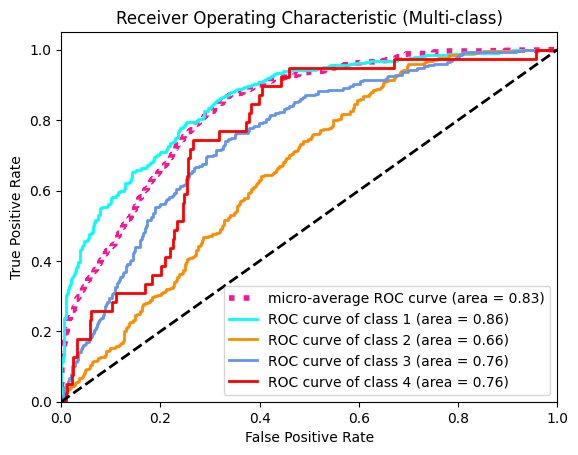

In [12]:
classes = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], predicted_probabilities_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), predicted_probabilities_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Adjust or extend for more classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()

# Overfitting

In [11]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [12]:
# Training Accuracy: 100, Validation Accuracy: 49
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(Y_train_cat.shape[1], activation='softmax')  # Output layer
])
# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), #RMS Prop can be better for small dataset
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train_cat, 
                    validation_data=(X_test, Y_test_cat), 
                    epochs=500,  # More epochs
                    batch_size=8)

Epoch 1/500


/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.4854 - loss: 1.1180 - val_accuracy: 0.5462 - val_loss: 0.9458
Epoch 2/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.5500 - loss: 0.9237 - val_accuracy: 0.5607 - val_loss: 0.8921
Epoch 3/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.5585 - loss: 0.8915 - val_accuracy: 0.5688 - val_loss: 0.8855
Epoch 4/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5599 - loss: 0.8988 - val_accuracy: 0.5788 - val_loss: 0.8477
Epoch 5/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.5550 - loss: 0.9047 - val_accuracy: 0.5960 - val_loss: 0.8435
Epoch 6/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.5607 - loss: 0.8948 - val_accuracy: 0.5779 - val_loss: 0.8402
Epoch 7/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.5650 - loss: 0.8892 - val_accuracy: 0.5942 - val_loss: 0.8475
Epoch 8/500
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.5669 - loss: 0.8886 - val_

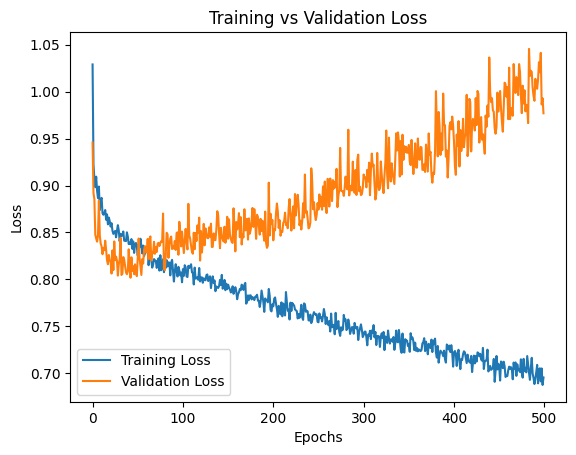

In [13]:
#Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

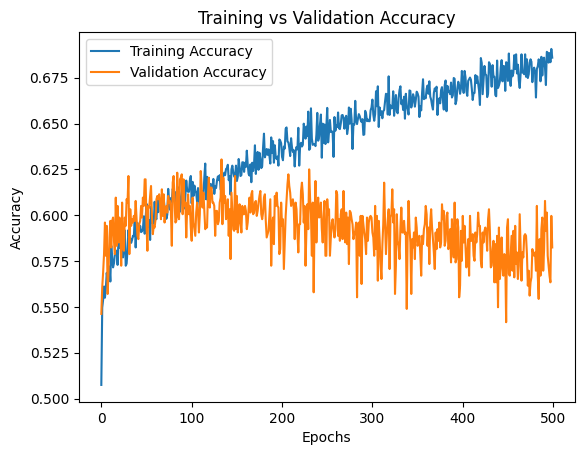

In [14]:
#Training Accuracy vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [15]:
pred_probs_test = model.predict(X_test)
pred_classes_test = np.argmax(pred_probs_test, axis=1) + 1

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


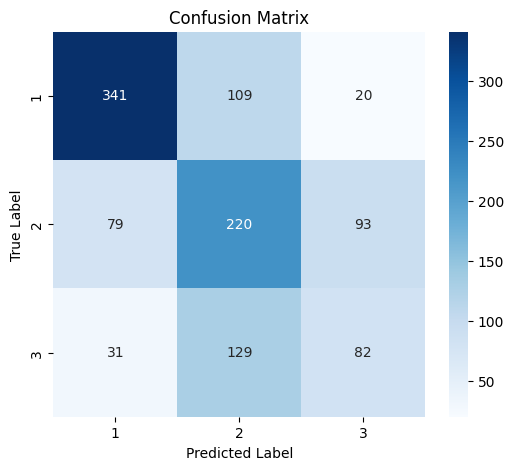

In [16]:
#Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(Y_test, pred_classes_test)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
print(classification_report(Y_test, pred_classes_test))

              precision    recall  f1-score   support

           1       0.76      0.73      0.74       470
           2       0.48      0.56      0.52       392
           3       0.42      0.34      0.38       242

    accuracy                           0.58      1104
   macro avg       0.55      0.54      0.54      1104
weighted avg       0.58      0.58      0.58      1104



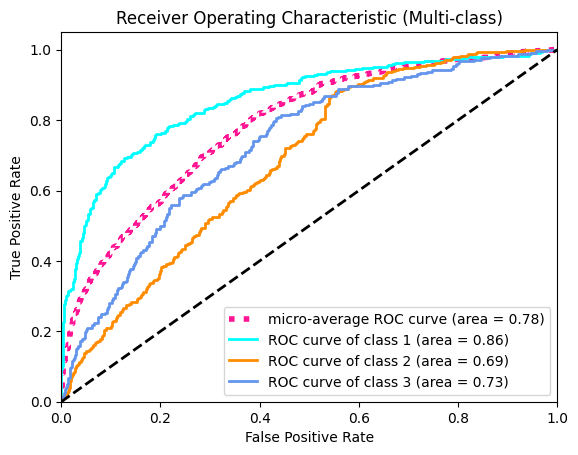

In [18]:
classes = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), pred_probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Adjust or extend for more classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()

# Avoiding Overfitting

In [27]:
# Validation Accuracy: 57

#Weighted vaerage computes the metric for each class, but then it averages them by 
#taking into account the support (i.e., the number of true instances for each class)

early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

model = keras.Sequential([
    
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),

    keras.layers.Dense(32, activation='relu'),
    Dropout(0.3),

    keras.layers.Dense(Y_train_cat.shape[1], activation='softmax')
])
# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), #RMS Prop can be better for small dataset
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train_cat, 
                    validation_data=(X_test, Y_test_cat), 
                    epochs=500,  # More epochs
                    batch_size=32,
                    callbacks=[early_stop]
                    )

Epoch 1/500


/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3706 - loss: 1.2751 - val_accuracy: 0.4900 - val_loss: 1.1064
Epoch 2/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.4700 - loss: 1.1201 - val_accuracy: 0.5226 - val_loss: 1.0312
Epoch 3/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5060 - loss: 1.0632 - val_accuracy: 0.5072 - val_loss: 1.0267
Epoch 4/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.5125 - loss: 1.0563 - val_accuracy: 0.5245 - val_loss: 0.9883
Epoch 5/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.5110 - loss: 1.0641 - val_accuracy: 0.5444 - val_loss: 0.9822
Epoch 6/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.5062 - loss: 1.0508 - val_accuracy: 0.5281 - val_loss: 0.9774
Epoch 7/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.5205 - loss: 1.0240 - val_accuracy: 0.5408 - val_loss: 0.9716
Epoch 8/500
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.5481 - loss: 1.0020 - val_ac

In [28]:
pred_probs_test = model.predict(X_test)
pred_classes_test = np.argmax(pred_probs_test, axis=1) + 1
pred_probs_train = model.predict(X_train_res)
pred_classes_train = np.argmax(pred_probs_train, axis=1) + 1

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


In [16]:
pred_probs_test
one_hot_array = np.eye(pred_probs_test.shape[1])[np.argmax(pred_probs_test, axis=1)]
one_hot_array

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

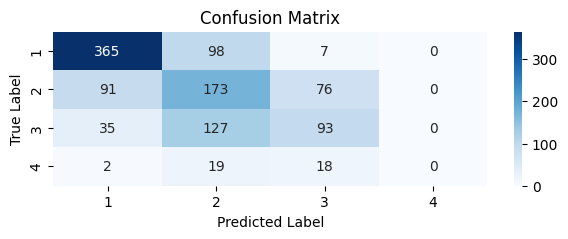

In [30]:
#Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(Y_test, pred_classes_test)
plt.figure(figsize=(7, 2))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

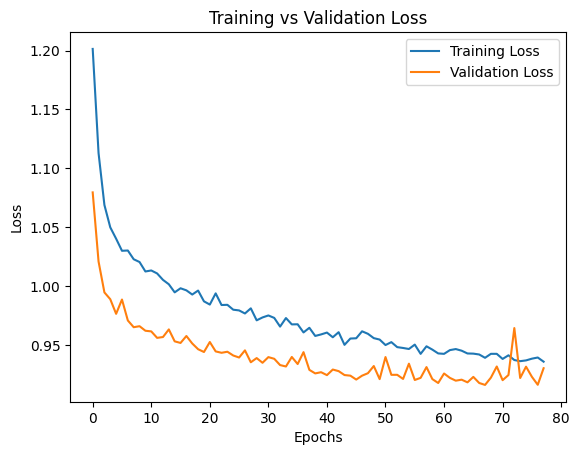

In [18]:
#Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

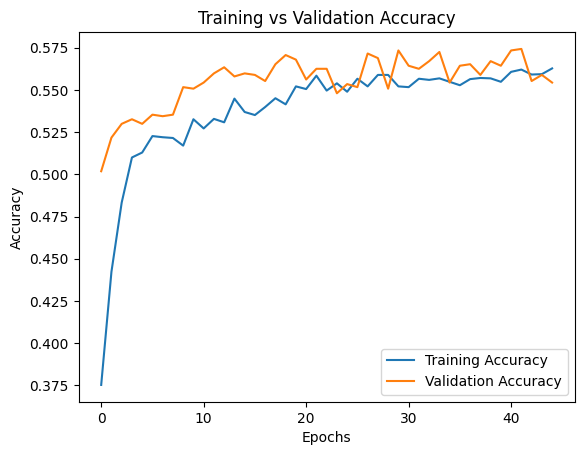

In [8]:
#Training Accuracy vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

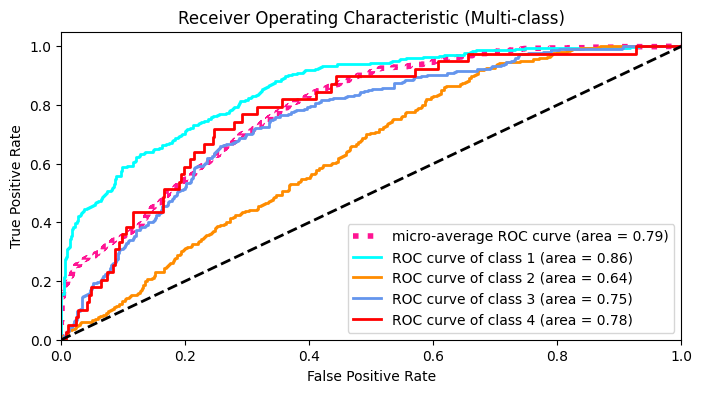

In [20]:
classes = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), pred_probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize = [8,4])
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Adjust or extend for more classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()

In [16]:
accuracy = accuracy_score(Y_test, pred_classes_test)
print("Test Accuracy:", accuracy)

# Compute accuracy
accuracy_train = accuracy_score(Y_train_res, pred_classes_train)
print("Train Accuracy:", accuracy_train)

print(classification_report(Y_test, pred_classes_test))
print(classification_report(Y_train_res, pred_classes_train))

Test Accuracy: 0.4746376811594203
Train Accuracy: 0.4755598033861278
              precision    recall  f1-score   support

           1       0.70      0.76      0.73       470
           2       0.39      0.35      0.37       340
           3       0.41      0.11      0.17       255
           4       0.10      0.56      0.17        39

    accuracy                           0.47      1104
   macro avg       0.40      0.44      0.36      1104
weighted avg       0.52      0.47      0.47      1104

              precision    recall  f1-score   support

           1       0.63      0.74      0.68      1831
           2       0.35      0.42      0.38      1831
           3       0.31      0.09      0.14      1831
           4       0.49      0.65      0.56      1831

    accuracy                           0.48      7324
   macro avg       0.45      0.48      0.44      7324
weighted avg       0.45      0.48      0.44      7324



# 3 Categories

In [ ]:
data_3 = pd.read_csv("Duolingo_data_03_07_final_standardized.csv")
data_3

In [ ]:
features = [col for col in data.columns if col not in ['churn_time_category', 'user_id', 'churn_time']]
X = data[features]
Y = data['churn_time_category']
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=42)
Y_train_cat = keras.utils.to_categorical(Y_train - 1)  # Subtracting 1 to align with 0-based indexing
Y_test_cat = keras.utils.to_categorical(Y_test - 1)
# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Validation Accuracy: 62

#Weighted vaerage computes the metric for each class, but then it averages them by 
#taking into account the support (i.e., the number of true instances for each class)

early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),

    keras.layers.Dense(32, activation='relu'),
    Dropout(0.3),

    keras.layers.Dense(Y_train_cat.shape[1], activation='softmax')
])
# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), #RMS Prop can be better for small dataset
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train_cat, 
                    validation_data=(X_test, Y_test_cat), 
                    epochs=500,  # More epochs
                    batch_size=32,
                    callbacks=[early_stop]
                    )

In [ ]:
pred_probs_test = model.predict(X_test)
pred_classes_test = np.argmax(pred_probs_test, axis=1) + 1

In [ ]:
#Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(Y_test, pred_classes_test)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
#Training Accuracy vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
classes = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), pred_probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Adjust or extend for more classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(Y_test, pred_classes_test))